# Using OpenMP parallelism
**smol** allows computing correlation functions and cluster interactions with openmp thread based parallelization, which can have important performance benefits for MC simulations of large systems or those with many allowed species.

The settings for the best performance improvements depend on the particular system and the machine being used, so we recommend that you always do a quick benchmark as illustrated in this notebook to find the optimal settings.

In [1]:
import numpy as np
from monty.serialization import loadfn
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure
from smol.cofe import ClusterSubspace, ClusterExpansion
from smol.moca import Ensemble, Sampler

### 0) Setup an ensemble and a sampler from a cluster expansion

In [2]:
# create a fake cluster expansion
prim = loadfn("data/lmof_prim.json")
subspace = ClusterSubspace.from_cutoffs(prim, {2: 5, 3: 4})
expansion = ClusterExpansion(subspace, np.random.random(len(subspace)))

# create a sgc ensemble
sc_matrix = 4 * np.eye(3)

# ClusterDecompositionProcessor is the default
ensemble_cd = Ensemble.from_cluster_expansion(expansion, sc_matrix)

# Create one with a ClusterExpansionProcessor
ensemble_ce = Ensemble.from_cluster_expansion(
    expansion, sc_matrix, processor_type="expansion"
)

# finally create a sampler
sampler = Sampler.from_ensemble(ensemble_cd, temperature=500, step_type="flip")

### 1) Setting the number of threads to benchmark parallelism improvements

The default number of threads is set to 2 when **smol** is built with openmp is enabled and the machine has at least 2 cores. The default number of threads can be overriden by setting the `OMP_NUM_THREADS` environment variable.

Additionally, the number of threads used can also be set for `ClusterSubspace`,  `ClusterExpansionProcessor`, and `ClusterDecompositionProcessor` instances at runtime.

In [3]:
# print the number of being threads used
print(f"The cluster_subspace is set to use {ensemble_cd.processor.cluster_subspace.num_threads} openmp threads for full computations.")
print(f"The processor is set to use {ensemble_cd.processor.num_threads_full} openmp threads for full computations.")
print(f"The processor is set to use {ensemble_cd.processor.num_threads} openmp threads to compute local changes.")

The cluster_subspace is set to use 2 openmp threads for full computations.
The processor is set to use 2 openmp threads for full computations.
The processor is set to use 2 openmp threads to compute local changes.


#### 1.1) Benchmark performance improvement for full computations
The attribute `num_threads_full` of the processor sets how many threads are used to compute a full vector, since this operation requires more computations compared to local changes it will usually have better performance gains when increasing the number of threads before the parallelization overhead becomes significant.

In [4]:
# We can get quick benchmark numbers using the %timeit magic function

occu = np.zeros(ensemble_cd.num_sites, dtype=int)

ensemble_cd.processor.num_threads_full = 1
%timeit ensemble_cd.compute_feature_vector(occu)

320 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
ensemble_cd.processor.num_threads_full = 2
%timeit ensemble_cd.compute_feature_vector(occu)

161 µs ± 573 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
ensemble_cd.processor.num_threads_full = 4
%timeit ensemble_cd.compute_feature_vector(occu)

92 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
# plot the scaling of performance gains
import os
from time import perf_counter

thread_range = range(1, os.cpu_count() + 1)
run_time_cd, run_time_ce = [], []
for num_threads in thread_range:
    run_time_cd.append(0), run_time_ce.append(0)
    ensemble_cd.processor.num_threads_full = num_threads
    ensemble_ce.processor.num_threads_full = num_threads
    for _ in range(1000):
        start = perf_counter()
        ensemble_cd.compute_feature_vector(occu)
        run_time_cd[-1] += perf_counter() - start
        
        start = perf_counter()
        ensemble_ce.compute_feature_vector(occu)
        run_time_ce[-1] += perf_counter() - start

run_time_cd, run_time_ce = np.array(run_time_cd), np.array(run_time_ce)

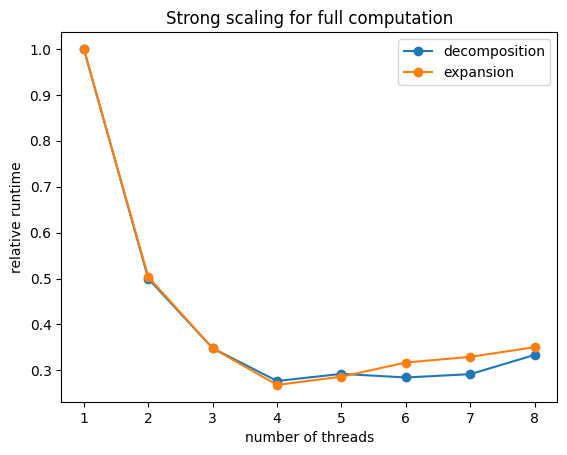

In [8]:
plt.plot(thread_range, run_time_cd / run_time_cd[0], 'o-')
plt.plot(thread_range, run_time_ce / run_time_ce[0], 'o-')
plt.title("Strong scaling for full computation")
plt.ylabel("relative runtime")
plt.xlabel("number of threads")
plt.legend(["decomposition", "expansion"])

#### 1.2) Benchmark performance improvement for computations of local changes
The attribute `num_threads` of the processor sets how many threads are used to compute a changes in a vector from local changes (aka flips/swaps/steps). Since the runtime of these calculations are nearly independent of supercell size, better performance improvements will likely be obtained for large expansions (ie those with a large number of clusters)

When running MC simulations this is the relevant place to set the number of threads.

In [17]:
# a fake flip
flip = [(0, 1)]

run_time_cd, run_time_ce = [], []
for num_threads in thread_range:
    run_time_cd.append(0), run_time_ce.append(0)
    ensemble_cd.processor.num_threads = num_threads
    ensemble_ce.processor.num_threads = num_threads
    for _ in range(50000):
        start = perf_counter()
        ensemble_cd.compute_feature_vector_change(occu, flip)
        run_time_cd[-1] += perf_counter() - start
        
        start = perf_counter()
        ensemble_ce.compute_feature_vector_change(occu, flip)
        run_time_ce[-1] += perf_counter() - start

run_time_cd, run_time_ce = np.array(run_time_cd), np.array(run_time_ce)

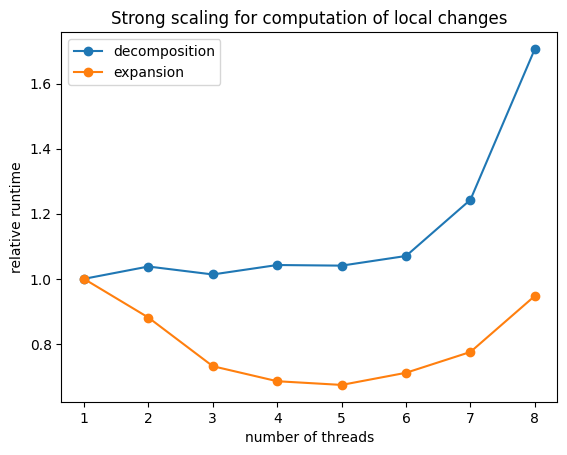

In [18]:
plt.plot(thread_range, run_time_cd / run_time_cd[0], 'o-')
plt.plot(thread_range, run_time_ce / run_time_ce[0], 'o-')
plt.title("Strong scaling for computation of local changes")
plt.ylabel("relative runtime")
plt.xlabel("number of threads")
plt.legend(["decomposition", "expansion"])